In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

In [2]:
# input files/dirs
CADD_SCORES_GENIC_REGION = "../results/cadd_scores_genic_regions"

# output files/dir
RESULTS_DIR = "../results/PCAWG"
os.makedirs(RESULTS_DIR, exist_ok=True)

## Normalized CADD Scores by genic region

In [3]:
files = os.listdir(CADD_SCORES_GENIC_REGION)
files = [f for f in files if f.endswith(".tsv") and "promoter" not in f]
print(files)

mut_genic_df = pd.DataFrame()
for f in files:
	df = pd.read_csv(f"{CADD_SCORES_GENIC_REGION}/{f}", sep="\t")
	df["cancer_type"] = f.split(".")[0]
	mut_genic_df = pd.concat([mut_genic_df, df])
mut_genic_df.reset_index(drop=True, inplace=True)
print(mut_genic_df.shape)

['CNS-Oligo.tsv', 'Kidney-ChRCC.tsv', 'Prost-AdenoCA.tsv', 'Kidney-RCC.tsv', 'Stomach-AdenoCA.tsv', 'CNS-Medullo.tsv', 'Thy-AdenoCA.tsv', 'Myeloid-MPN.tsv', 'Bone-Leiomyo.tsv', 'Lymph-BNHL.tsv', 'Myeloid-AML.tsv', 'Lung-AdenoCA.tsv', 'CNS-GBM.tsv', 'Head-SCC.tsv', 'Breast-AdenoCa.tsv', 'Ovary-AdenoCA.tsv', 'CNS-PiloAstro.tsv', 'Cervix-SCC.tsv', 'Liver-HCC.tsv', 'Bone-Osteosarc.tsv', 'Biliary-AdenoCA.tsv', 'Skin-Melanoma.tsv', 'Lung-SCC.tsv', 'Lymph-CLL.tsv', 'Panc-Endocrine.tsv', 'Bladder-TCC.tsv', 'Panc-AdenoCA.tsv', 'ColoRect-AdenoCA.tsv', 'Breast-LobularCa.tsv', 'Eso-AdenoCa.tsv', 'Uterus-AdenoCA.tsv']
(77042, 17)


In [4]:
# calculate cohen's d for each genic region
from statsmodels.stats.weightstats import DescrStatsW
genic_regions = mut_genic_df["genic_region"].unique().tolist()
cohens_d_results = []
for region in genic_regions:
    region_data = mut_genic_df[mut_genic_df["genic_region"] == region]
    group1 = region_data[region_data["has_driver"] == "Passengers in presence of driver"]["CADD_score_normalized"]
    group2 = region_data[region_data["has_driver"] == "Passengers in absence of driver"]["CADD_score_normalized"]
    if len(group1) > 1 and len(group2) > 1:
        d1 = DescrStatsW(group1)
        d2 = DescrStatsW(group2)
        cohen_d = (d1.mean - d2.mean) / np.sqrt(((d1.var + d2.var) / 2))
        cohens_d_results.append({"genic_region": region, "cohen_d": cohen_d})
cohens_d_df = pd.DataFrame(cohens_d_results)
cohens_d_df.sort_values(by="cohen_d", ascending=False, inplace=True)
print(cohens_d_df)

# source data
cohens_d_df.to_csv(f"{RESULTS_DIR}/cadd_scores_genic_regions_cohens_d.tsv", sep="\t", index=False)

  genic_region   cohen_d
5   downstream  0.206613
3         UTR3 -0.116313
0       exonic -0.258932
2     intronic -0.426433
6        ncRNA -0.513096
8         UTR5 -1.039999
4   intergenic -1.077322
1     splicing -1.386668
7     upstream -2.218202


[(('exonic', 'Passengers in presence of driver'), ('exonic', 'Passengers in absence of driver')), (('UTR5', 'Passengers in presence of driver'), ('UTR5', 'Passengers in absence of driver')), (('upstream', 'Passengers in presence of driver'), ('upstream', 'Passengers in absence of driver')), (('UTR3', 'Passengers in presence of driver'), ('UTR3', 'Passengers in absence of driver')), (('intronic', 'Passengers in presence of driver'), ('intronic', 'Passengers in absence of driver')), (('downstream', 'Passengers in presence of driver'), ('downstream', 'Passengers in absence of driver'))]


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_2906/4014870885.py:16: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

UTR5_Passengers in presence of driver vs. UTR5_Passengers in absence of driver: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:2.467e-05 U_stat=1.412e+03
exonic_Passengers in presence of driver vs. exonic_Passengers in absence of driver: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:2.408e-03 U_stat=7.722e+04
upstream_Passengers in presence of driver vs. upstream_Passengers in absence of driver: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:1.089e-08 U_stat=2.620e+02
intronic_Passengers in presence of driver vs. intron

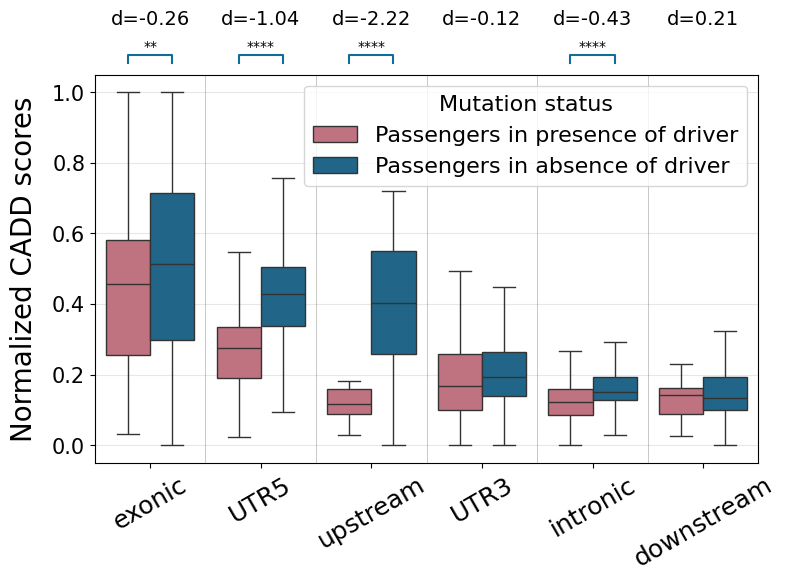

In [5]:
plt.figure(figsize=(8, 6))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)

# sort genic region by median CADD scores
median_values = mut_genic_df.groupby(["genic_region"])["CADD_score_normalized"].median().reset_index()
median_values.sort_values(by="CADD_score_normalized", ascending=False, inplace=True)
median_values_order = median_values["genic_region"].tolist()
unwanted_regions = ["-", "splicing", "intergenic", "ncRNA"]
for region in unwanted_regions:
	if region in median_values_order:
		median_values_order.remove(region)

hue_order = ["Passengers in presence of driver", "Passengers in absence of driver"]

ax = sns.boxplot(
    x="genic_region",
	y="CADD_score_normalized",
	hue="has_driver",
	data=mut_genic_df,
	order=median_values_order,
    hue_order=hue_order,
    palette=cmap,
	showfliers=False
)

# add grid lines
ax.grid(axis='y', alpha=0.3)
for i in range(len(median_values_order) - 1):
	ax.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)
     
# add statistical significance annotations
box_pairs = []
for region in median_values_order:
    region_data = mut_genic_df[mut_genic_df["genic_region"] == region]
    if len(region_data["has_driver"].unique().tolist()) >= 2:
        box_pairs.append(((region, "Passengers in presence of driver"), (region, "Passengers in absence of driver")))
print(box_pairs)

annotator = Annotator(
    ax, 
    data=mut_genic_df,
    x="genic_region",
    y="CADD_score_normalized", 
    hue="has_driver",
    order=median_values_order,
    hue_order=hue_order,
    pairs=box_pairs,
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

# annotate cohen's d values on the plot
for index, row in cohens_d_df.iterrows():
    region = row["genic_region"]
    cohen_d = row["cohen_d"]
    if region in median_values_order:
        x_pos = median_values_order.index(region)
        y_pos = 1.18  # position above the boxplot
        ax.text(x_pos, y_pos, f"d={cohen_d:.2f}", ha='center', va='bottom', fontsize=14, color='black')

plt.xlabel("", labelpad=10)
plt.xticks(rotation=30, fontsize=18)
plt.ylabel("Normalized CADD scores", fontsize=20, labelpad=10)
plt.yticks(fontsize=15)
plt.legend(title="Mutation status", fontsize=16, title_fontsize=16)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/cadd_scores_by_genic_region.png", dpi=300)